In [1]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Eagleeye2045
Your Kaggle Key: ········
Dataset URL: https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered


100%|███████████████████████████████████████████████████████████████████████████████| 427M/427M [03:44<00:00, 1.99MB/s]


In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import cv2
import shutil
import keras
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
import seaborn as sns

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import PIL
import plotly
import plotly.express as px

In [101]:
df = pd.read_csv("C:/Users/rtani/Downloads/train.csv")

diagnosis_binary = {
        0: 'No_DR',
        1: 'DR',
        2: 'DR',
        3: 'DR',
        4: 'DR'}

diagnosis_classes = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df["binary"] = df["diagnosis"].map(diagnosis_binary.get)
df["type"] = df["diagnosis"].map(diagnosis_classes.get)

In [3]:
df.head()

id_code  diagnosis binary            type
0  000c1434d8d7          2     DR        Moderate
1  001639a390f0          4     DR  Proliferate_DR
2  0024cdab0c1e          1     DR            Mild
3  002c21358ce6          0  No_DR           No_DR
4  005b95c28852          0  No_DR           No_DR

<Axes: xlabel='diagnosis', ylabel='count'>

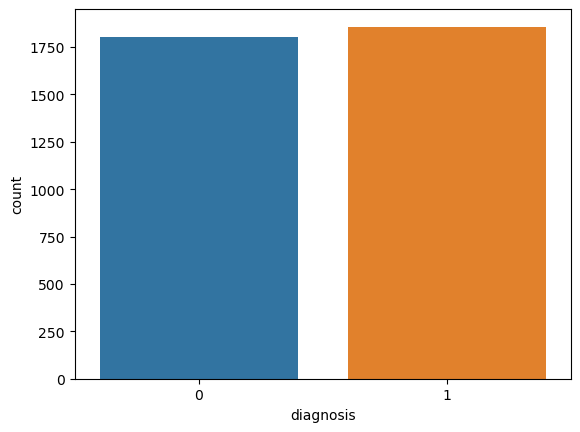

In [4]:
df['diagnosis'] = df['diagnosis'] > 0
df['diagnosis'] = df['diagnosis'].astype('int32')

# plot the distribution of categories
sns.countplot(data=df, x='diagnosis')

<Axes: >

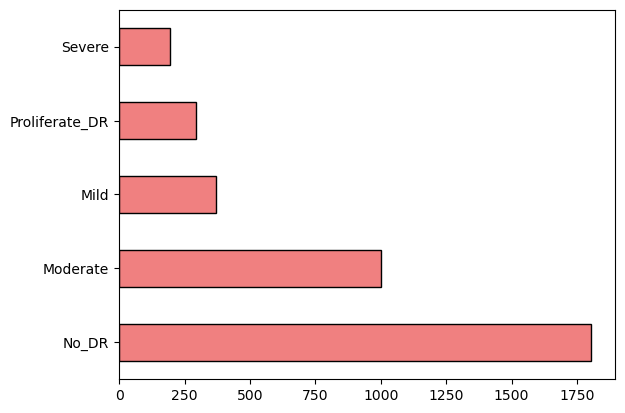

In [5]:
df['type'].value_counts().plot(kind='barh', color='lightcoral', edgecolor='black')

In [102]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(df['binary'])
df['binary'] = encoded_labels
df.head()

id_code  diagnosis  binary            type
0  000c1434d8d7          2       0        Moderate
1  001639a390f0          4       0  Proliferate_DR
2  0024cdab0c1e          1       0            Mild
3  002c21358ce6          0       1           No_DR
4  005b95c28852          0       1           No_DR

In [103]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

encoder = OneHotEncoder()

one_hot_encoded = encoder.fit_transform(df[['type']]).toarray()

one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['type']))

df = pd.concat([df, one_hot_encoded_df], axis=1)

# Drop the original categorical column 'Type'
df.drop('type', axis=1, inplace=True)

df.head()

id_code  diagnosis  binary  type_Mild  type_Moderate  type_No_DR  \
0  000c1434d8d7          2       0        0.0            1.0         0.0   
1  001639a390f0          4       0        0.0            0.0         0.0   
2  0024cdab0c1e          1       0        1.0            0.0         0.0   
3  002c21358ce6          0       1        0.0            0.0         1.0   
4  005b95c28852          0       1        0.0            0.0         1.0   

   type_Proliferate_DR  type_Severe  
0                  0.0          0.0  
1                  1.0          0.0  
2                  0.0          0.0  
3                  0.0          0.0  
4                  0.0          0.0

In [7]:
path = 'diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
No_DR_Img = os.listdir(path + '/No_DR/')
Mild_Img = os.listdir(path + '/Mild/')
Moderate_Img = os.listdir(path + '/Moderate/')
Proliferate_DR_Img = os.listdir(path + '/Proliferate_DR/')
Severe_Img = os.listdir(path + '/Severe/')

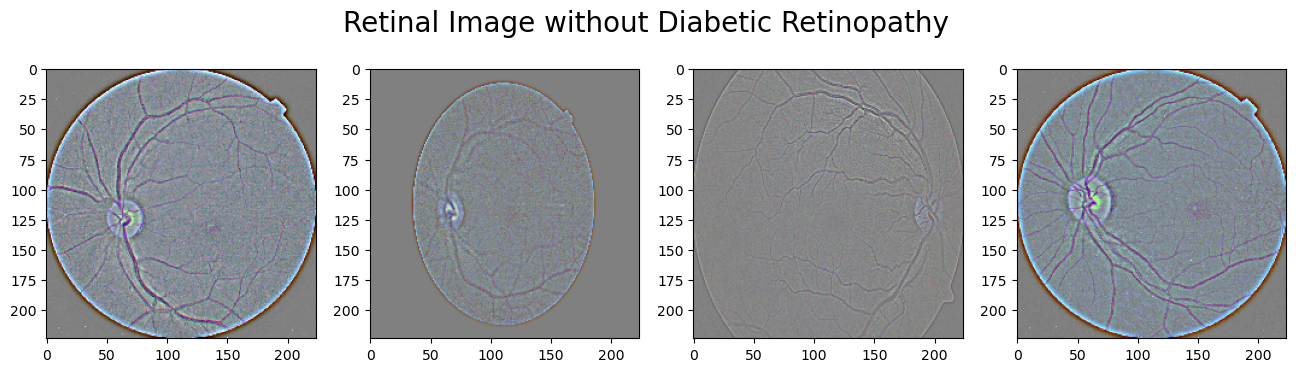

In [8]:
fig = plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread(path+'/No_DR/'+ No_DR_Img[i])
    plt.imshow(img)
plt.suptitle("Retinal Image without Diabetic Retinopathy",fontsize=20)
plt.show()

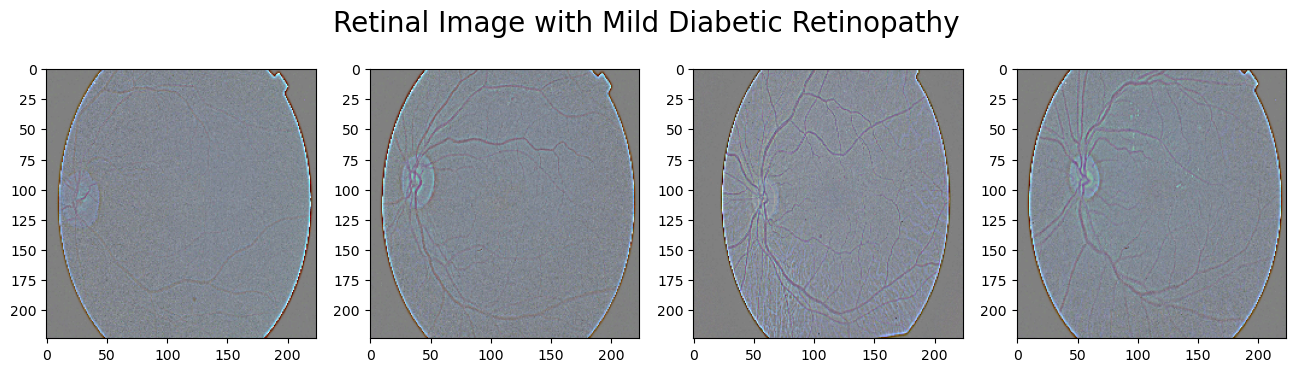

In [9]:
fig = plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread(path+'/Mild/'+ Mild_Img[i])
    plt.imshow(img)
plt.suptitle("Retinal Image with Mild Diabetic Retinopathy",fontsize=20)
plt.show()

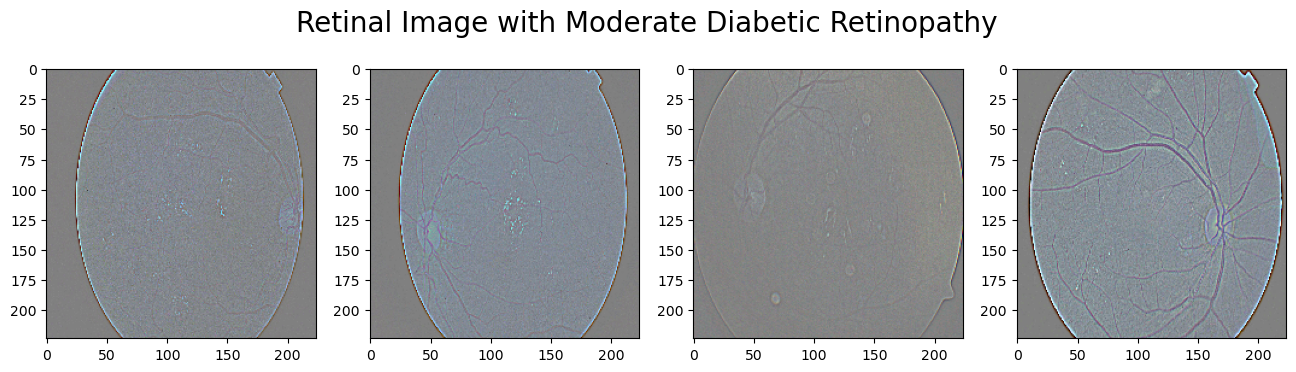

In [10]:
fig = plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread(path+'/Moderate/'+ Moderate_Img[i])
    plt.imshow(img)
plt.suptitle("Retinal Image with Moderate Diabetic Retinopathy",fontsize=20)
plt.show()

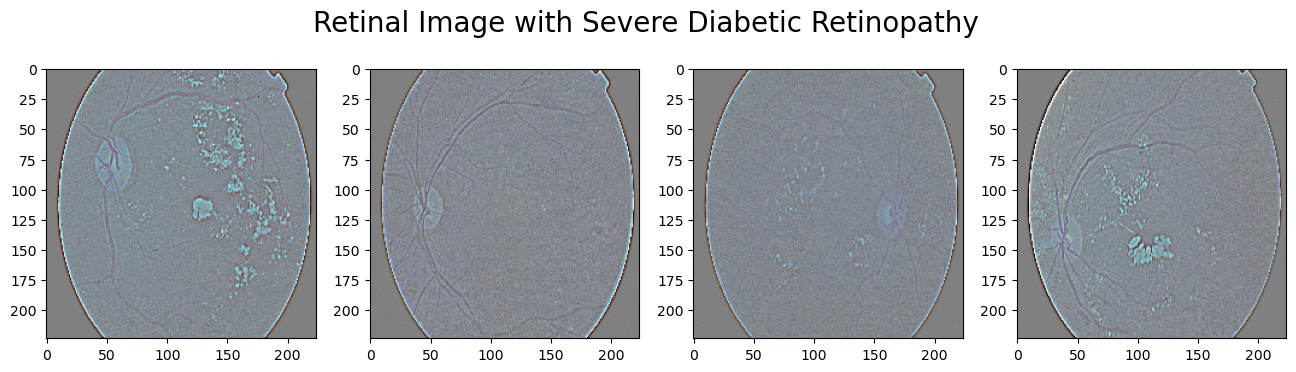

In [11]:
fig = plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread(path+'/Severe/'+ Severe_Img[i])
    plt.imshow(img)
plt.suptitle("Retinal Image with Severe Diabetic Retinopathy",fontsize=20)
plt.show()

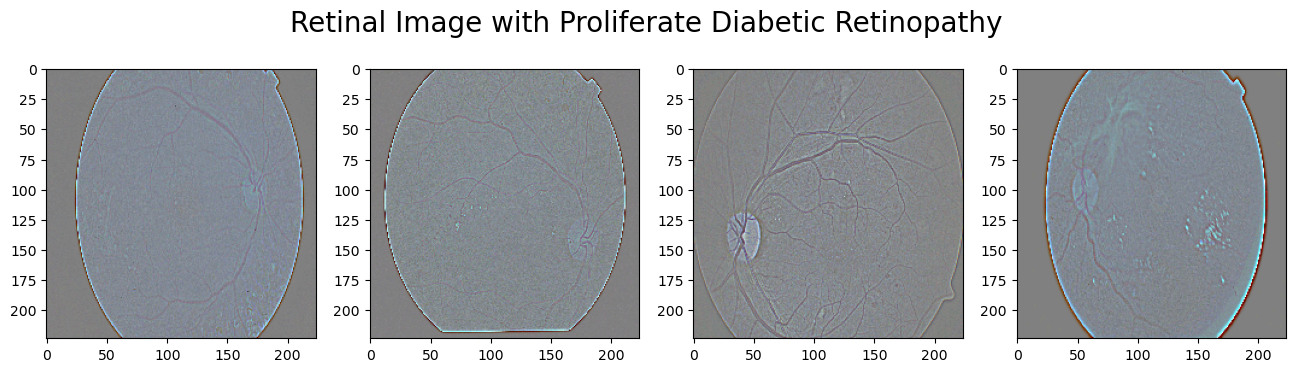

In [12]:
fig = plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread(path+'/Proliferate_DR/'+ Proliferate_DR_Img[i])
    plt.imshow(img)
plt.suptitle("Retinal Image with Proliferate Diabetic Retinopathy",fontsize=20)
plt.show()

In [13]:
Classes = {'No_DR':0, 'Mild':1, 'Moderate':2, 'Severe':3, 'Proliferate_DR':4}

In [14]:
X = []
y = []
for i in Classes:
    folder_path ='diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/' +i
    for j in os.listdir(folder_path):
        img = cv2.imread(folder_path+'/'+j)
        # normalize values
        img = img / 255  #-->Apply normalization because we want pixel values to be scaled to the range 0-1
        X.append(img)
        y.append(Classes[i])

In [15]:
X = np.array(X)
y = np.array(y)

X.shape, y.shape

((3662, 224, 224, 3), (3662,))

In [16]:
Class_series=pd.Series(y)
lis=["No_DR","Mild","Moderate","Severe","Proliferate_DR"]
DR_or_not = Class_series.value_counts().tolist()
values = [DR_or_not[0], DR_or_not[1], DR_or_not[2], DR_or_not[3], DR_or_not[4]]
fig = px.pie(values=Class_series.value_counts(), names=lis , width=800, height=400, color_discrete_sequence=["skyblue","black","pink","purple","blue"]
             ,title="percentage among the different Severities of DR")
fig.show()

In [17]:
#from imblearn.over_sampling import SMOTE
#Using SMOTE to oversample the minority class to avoid class imbalance
#sm = SMOTE(random_state = 2)
#sm = SMOTE(random_state = 2)
#X, y = sm.fit_resample(X.reshape(X.shape[0], -1), y.ravel())

In [18]:
#Class_series=pd.Series(y)
#lis=["No_DR","Mild","Moderate","Severe","Proliferate_DR"]
#DR_or_not = Class_series.value_counts().tolist()
#values = [DR_or_not[0], DR_or_not[1], DR_or_not[2], DR_or_not[3], DR_or_not[4]]
#fig = px.pie(values=Class_series.value_counts(), names=lis , width=800, height=400, color_discrete_sequence=["skyblue","black","pink","purple","blue"]
#             ,title="percentage among the different Severities of DR")
#fig.show()


In [19]:
import gc
gc.collect()

26975

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=32, stratify=y)
X_train = X_train.reshape( (-1,224,224,3))
X_test = X_test.reshape((-1,224,224,3))

In [21]:
from keras.applications.vgg16 import VGG16

In [24]:
vgg = VGG16(include_top=False,weights='imagenet', input_shape= (224,224,3))

In [25]:
vgg.trainable = True

set_trainable = False

for layer in vgg.layers:
    if layer.name == 'conv5_block16_0_bn':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [26]:
for layer in vgg.layers[:]:
  if ('bn' in layer.name):
    trainable = False

In [27]:
from tensorflow.keras.layers import Dense,Flatten,Input,Dropout,Activation,BatchNormalization,Lambda
from tensorflow.keras.models import Model

In [28]:
x = Flatten()(vgg.output)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
prediction = Dense(5,activation='softmax')(x)

In [29]:
model = Model(inputs=vgg.input, outputs=prediction)

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

In [33]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

#Early Stopping

es = EarlyStopping(monitor='val_accuracy', min_delta = 0.01, patience=5, verbose=1, mode='auto')

#Model Check Point

mc = ModelCheckpoint(monitor='val_accuracy', filepath = '/kaggle/working/diabetic-retinopathy-224x224-gaussian-filtered/DR-model.h5', verbose=1, save_best_only = True, mode='auto')

cd = [es,mc]

In [34]:
adam = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = adam,
              metrics=['accuracy']
)

In [35]:
model.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          epochs=5,
          callbacks=cd,
          batch_size = 32,
          shuffle=True)

Epoch 1/5


92/92 [==============================] - ETA: 0s - loss: 1.1072 - accuracy: 0.5838
Epoch 1: val_accuracy improved from -inf to 0.70532, saving model to /kaggle/working/diabetic-retinopathy-224x224-gaussian-filtered\DR-model.h5


C:\Users\rtani\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



92/92 [==============================] - 334s 4s/step - loss: 1.1072 - accuracy: 0.5838 - val_loss: 0.8418 - val_accuracy: 0.7053
Epoch 2/5
92/92 [==============================] - ETA: 0s - loss: 0.8959 - accuracy: 0.6832
Epoch 2: val_accuracy improved from 0.70532 to 0.72033, saving model to /kaggle/working/diabetic-retinopathy-224x224-gaussian-filtered\DR-model.h5
92/92 [==============================] - 310s 3s/step - loss: 0.8959 - accuracy: 0.6832 - val_loss: 0.7997 - val_accuracy: 0.7203
Epoch 3/5
92/92 [==============================] - ETA: 0s - loss: 0.8558 - accuracy: 0.6972
Epoch 3: val_accuracy improved from 0.72033 to 0.72715, saving model to /kaggle/working/diabetic-retinopathy-224x224-gaussian-filtered\DR-model.h5
92/92 [==============================] - 302s 3s/step - loss: 0.8558 - accuracy: 0.6972 - val_loss: 0.7730 - val_accuracy: 0.7271
Epoch 4/5
92/92 [==============================] - ETA: 0s - loss: 0.8320 - accuracy: 0.7060
Epoch 4: val_accuracy improved from 0

In [36]:
history = model.history.history
model_loss=pd.DataFrame(model.history.history)

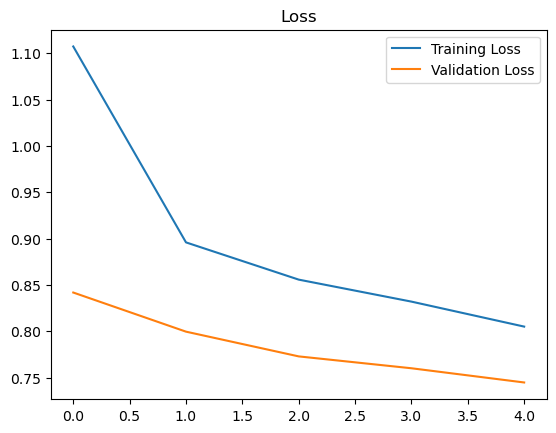

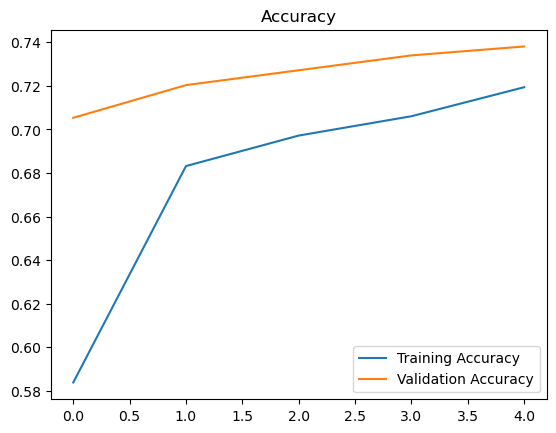

In [40]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

     # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

plot_metrics(history)

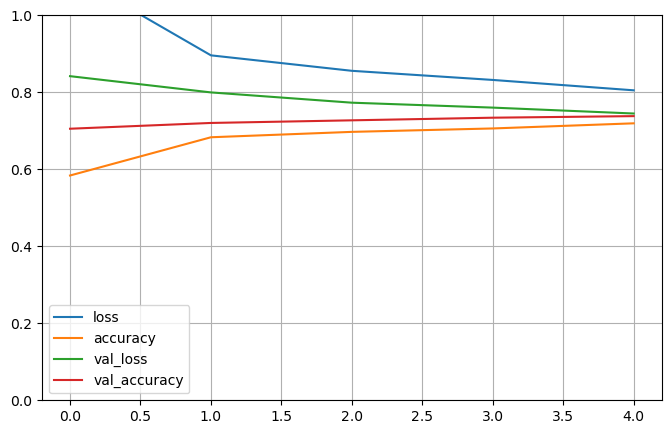

In [41]:
model_loss.plot (figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [42]:
Model_evaluation = model.evaluate(X_train, y_train)
print(f"%\nAccuracy: {Model_evaluation[1]*100:.4f} %")


92/92 [==============================] - 241s 3s/step - loss: 0.7617 - accuracy: 0.7282
%
Accuracy: 72.8235 %


In [43]:
y_predicted_tf = model.predict(X_test)

23/23 [==============================] - 65s 3s/step


In [49]:
y_predicted =[]
for i in range(733):
    max_val = y_predicted_tf[i][0]
    classify = 0
    for j in range(5):
        if max_val<y_predicted_tf[i][j]:
            max_val = y_predicted_tf[i][j]
            classify = j
    y_predicted.append(classify)

In [50]:
len(y_predicted)

733

In [51]:
dff = pd.DataFrame({"Y_test": y_test , "Y_predicted" : y_predicted})
dff.head(8)

Y_test  Y_predicted
0       4            2
1       0            0
2       2            2
3       0            0
4       0            0
5       0            0
6       4            2
7       1            2

In [ ]:
'''input_layer = tf.keras.layers.Input(shape = (224, 224, 3))

max_pool = tf.keras.layers.MaxPooling2D(pool_size = (3, 3))

conv2d1 = tf.keras.layers.Conv2D(8, kernel_size = (3, 3), activation = 'relu')
batch_norm1 = tf.keras.layers.BatchNormalization()

conv2d2 = tf.keras.layers.Conv2D(8, kernel_size = (3, 3), activation = 'relu')
batch_norm2 = tf.keras.layers.BatchNormalization()

conv2d3 = tf.keras.layers.Conv2D(8, kernel_size = (3, 3), activation = 'relu')
batch_norm3 = tf.keras.layers.BatchNormalization()
conv2d4 = tf.keras.layers.Conv2D(8, kernel_size = (3, 3), activation = 'relu')
batch_norm4 = tf.keras.layers.BatchNormalization()

flatten = tf.keras.layers.Flatten()

dense1 = tf.keras.layers.Dense(50, activation = 'relu')
dropout1 = tf.keras.layers.Dropout(.2)

predict = tf.keras.layers.Dense(2, activation = 'softmax')

x = input_layer

x = conv2d1(x)
x = max_pool(x)
x = batch_norm1(x)
x = conv2d2(x)
x = max_pool(x)
x = batch_norm2(x)

x = conv2d3(x)
x = max_pool(x)
x = batch_norm3(x)

x = flatten(x)
x = dense1(x)
x = dropout1(x)

custom_model = tf.keras.Model(input_layer, predict(x))
custom_model.summary()'''

In [ ]:
'''
custom_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
    metrics = ['accuracy',
               tf.keras.metrics.Precision(),
               tf.keras.metrics.Recall()],
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
)

history_custom = custom_model.fit(
    train_data,
    epochs = 5,
    validation_data = val_data
)'''

In [ ]:
'''loss, accuracy, _, _ = custom_model.evaluate(test_data)
report_dict['custom-model'] = [loss, accuracy]'''

In [ ]:
'''def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("Training and validation loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("Training and Validation accuracy")
  plt.xlabel("epochs")
  plt.legend()

plot_curves(history)'''

In [ ]:
"""print('Test Results\n')
for model_name in report_dict:
    loss_val = report_dict[model_name][0]
    accu_val = report_dict[model_name][1]
    print(f'{model_name:50s}| loss: {loss_val:8.3f} | accuracy: {accu_val:.2%}')"""

In [ ]:
"""preds = model.predict(test_data)
pred = np.argmax(preds, axis=1)"""

In [ ]:
"""for i in range(len(pred)):
  if pred[i] > 0:
    pred[i] = 1;
"""

In [53]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

In [ ]:
print(classification_report(test_data.classes, pred, target_names= classes))

In [54]:
cm = confusion_matrix(y_test, y_predicted)
print(cm)

[[353   0   8   0   0]
 [ 10   7  57   0   0]
 [ 15   4 181   0   0]
 [  4   1  34   0   0]
 [  6   2  51   0   0]]


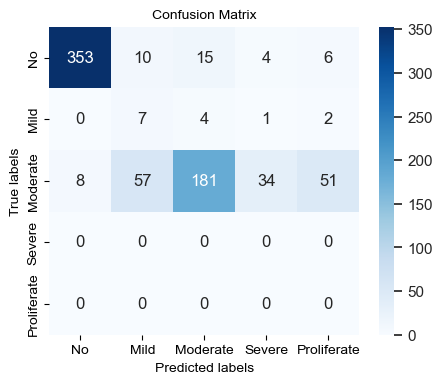

In [55]:
cm = confusion_matrix(y_predicted,y_test)

plt.figure(figsize=(5, 4))
ax = plt.subplot()
sns.set(font_scale=1.0)
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=10);ax.set_ylabel('True labels', fontsize=10);
ax.set_title('Confusion Matrix', fontsize=10);
ax.xaxis.set_ticklabels(['No','Mild','Moderate','Severe','Proliferate'], fontsize=10); ax.yaxis.set_ticklabels(['No','Mild','Moderate','Severe','Proliferate'], fontsize=10);

In [56]:
from sklearn import metrics
print(metrics.classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       361
           1       0.50      0.09      0.16        74
           2       0.55      0.91      0.68       200
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00        59

    accuracy                           0.74       733
   macro avg       0.39      0.40      0.36       733
weighted avg       0.65      0.74      0.67       733



C:\Users\rtani\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\rtani\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\rtani\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [57]:
from keras.applications.resnet import ResNet50
rn50 = ResNet50(include_top=False, input_shape= (224,224,3))
rn50.trainable=False

94765736/94765736 [==============================] - 8s 0us/step


In [61]:
rn50 = ResNet50(include_top=False,weights='imagenet', input_shape= (224,224,3))

In [62]:
rn50.trainable = True

set_trainable = False

for layer in rn50.layers:
    if layer.name == 'conv5_block16_0_bn':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [63]:
for layer in rn50.layers[:]:
  if ('bn' in layer.name):
    trainable = False

In [64]:
x = Flatten()(rn50.output)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
prediction = Dense(5,activation='softmax')(x)

In [66]:
model1 = Model(inputs=rn50.input, outputs=prediction)
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
primary_learning_rate = 1e-4

rn50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=primary_learning_rate),
                       loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                       metrics=['accuracy',
                                tf.keras.metrics.Precision(),
                                tf.keras.metrics.Recall()]
)

In [68]:
gc.collect()
X=[]
y=[]

In [69]:
early_stop1 = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

In [70]:
#Early Stopping

es1 = EarlyStopping(monitor='val_accuracy', min_delta = 0.01, patience=5, verbose=1, mode='auto')

#Model Check Point

mc1 = ModelCheckpoint(monitor='val_accuracy', filepath = '/kaggle/working/diabetic-retinopathy-224x224-gaussian-filtered/DR-model.h5', verbose=1, save_best_only = True, mode='auto')

cd1 = [es1,mc1]

In [71]:

adam1 = keras.optimizers.Adam(learning_rate=0.00001)
model1.compile(loss='sparse_categorical_crossentropy',
              optimizer = adam1,
              metrics=['accuracy']
)

In [72]:
model1.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          epochs=5,
          callbacks=cd1,
          batch_size = 32,
          shuffle=True)

Epoch 1/5
92/92 [==============================] - ETA: 0s - loss: 1.3443 - accuracy: 0.5275
Epoch 1: val_accuracy improved from -inf to 0.66439, saving model to /kaggle/working/diabetic-retinopathy-224x224-gaussian-filtered\DR-model.h5


C:\Users\rtani\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



92/92 [==============================] - 188s 2s/step - loss: 1.3443 - accuracy: 0.5275 - val_loss: 0.9768 - val_accuracy: 0.6644
Epoch 2/5
92/92 [==============================] - ETA: 0s - loss: 1.0159 - accuracy: 0.6268
Epoch 2: val_accuracy improved from 0.66439 to 0.67667, saving model to /kaggle/working/diabetic-retinopathy-224x224-gaussian-filtered\DR-model.h5
92/92 [==============================] - 178s 2s/step - loss: 1.0159 - accuracy: 0.6268 - val_loss: 0.9232 - val_accuracy: 0.6767
Epoch 3/5
92/92 [==============================] - ETA: 0s - loss: 0.9788 - accuracy: 0.6429
Epoch 3: val_accuracy did not improve from 0.67667
92/92 [==============================] - 179s 2s/step - loss: 0.9788 - accuracy: 0.6429 - val_loss: 0.9011 - val_accuracy: 0.6739
Epoch 4/5
92/92 [==============================] - ETA: 0s - loss: 0.9653 - accuracy: 0.6572
Epoch 4: val_accuracy improved from 0.67667 to 0.68349, saving model to /kaggle/working/diabetic-retinopathy-224x224-gaussian-filtere

In [81]:
history = model1.history.history
model_loss =pd.DataFrame(model1.history.history)

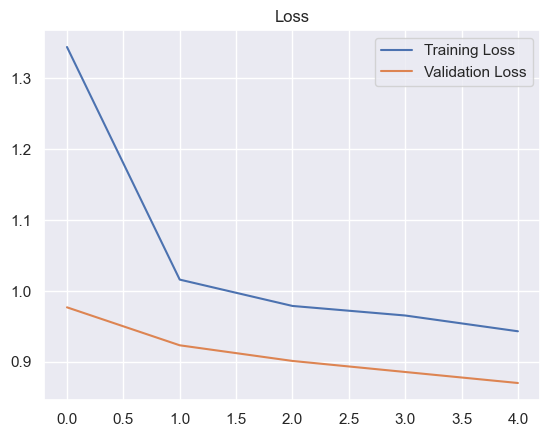

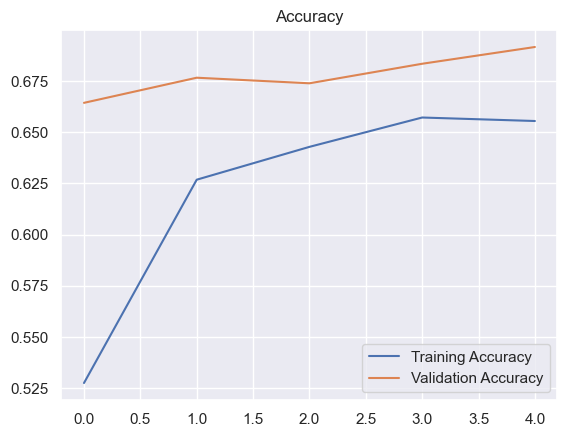

In [82]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

     # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

plot_metrics(history)

In [83]:
Model_evaluation1 = model.evaluate(X_train, y_train)
print(f"%\nAccuracy: {Model_evaluation1[1]*100:.4f} %")

92/92 [==============================] - 233s 3s/step - loss: 0.7617 - accuracy: 0.7282
%
Accuracy: 72.8235 %


In [84]:
y_predicted_tf1 = model1.predict(X_test)

23/23 [==============================] - 32s 1s/step


In [86]:
y_predicted1 =[]
for i in range(733):
    max_val = y_predicted_tf1[i][0]
    classify = 0
    for j in range(5):
        if max_val<y_predicted_tf1[i][j]:
            max_val = y_predicted_tf1[i][j]
            classify = j
    y_predicted1.append(classify)

In [87]:
cm1 = confusion_matrix(y_test, y_predicted1)
print(cm1)

[[317   0  44   0   0]
 [  7   0  67   0   0]
 [ 10   0 190   0   0]
 [  4   0  35   0   0]
 [  1   0  58   0   0]]


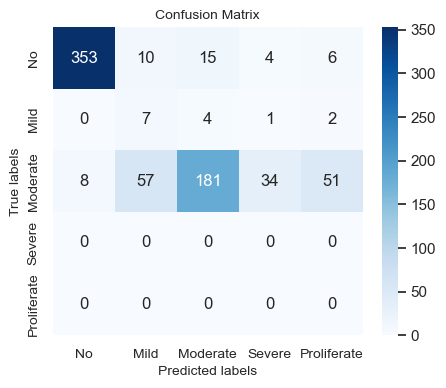

In [88]:
cm1 = confusion_matrix(y_predicted1,y_test)

plt.figure(figsize=(5, 4))
ax = plt.subplot()
sns.set(font_scale=1.0)
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=10);ax.set_ylabel('True labels', fontsize=10);
ax.set_title('Confusion Matrix', fontsize=10);
ax.xaxis.set_ticklabels(['No','Mild','Moderate','Severe','Proliferate'], fontsize=10); ax.yaxis.set_ticklabels(['No','Mild','Moderate','Severe','Proliferate'], fontsize=10);

In [89]:
print(metrics.classification_report(y_test,y_predicted1))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       361
           1       0.00      0.00      0.00        74
           2       0.48      0.95      0.64       200
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00        59

    accuracy                           0.69       733
   macro avg       0.28      0.37      0.31       733
weighted avg       0.59      0.69      0.62       733



C:\Users\rtani\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\rtani\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\rtani\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

